In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science','grid']) ############## THIS ONE TO COOL EVERYTHING
from string import digits
import re

from IPython.display import display

In [ ]:
location_figures = 'figures_timeslot/'

In [ ]:
### GENERAL DATA

number_of_policies = 2
number_of_replications = 10
number_of_scenarios = 2
number_of_timeslots = 2

## palettes
pal_scenarios = {0: "tab:orange", 1: "tab:purple"}
pal_attitudes = {"Cooperative": "tab:gray", "Competitive": "tab:pink", 'New-competitive':"tab:olive"}
pal_scenarios_10 = {10: "tab:orange", 30: "tab:purple"}

In [ ]:
### .CSV FILE: with info per tick
exp6df = pd.read_csv("data/exp6df.csv",)
print("I have finished reading the .csv file!")

I have finished reading the .csv file!


In [ ]:
import pickle

f = open("data/timeslot_first.pkl", "rb")
total_dict = pickle.load(f)
f.close()

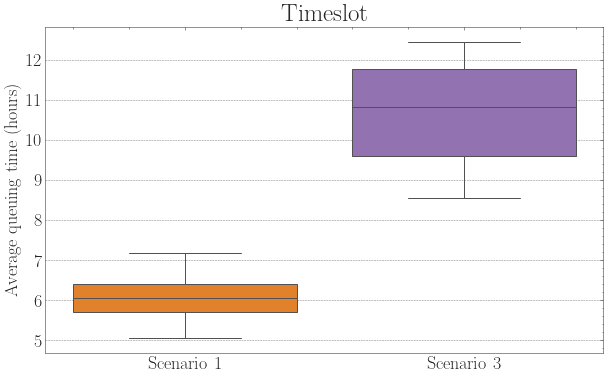

In [ ]:
# Average time in queue across all queuing agents
policy = 0
timeslot = 1

# per scenario give a boxplot of the average waiting time (sum of every key of 10 / 3)
fig, ax = plt.subplots(figsize = (10, 6))
matrix = np.zeros([number_of_replications*number_of_scenarios,3])


# print(matrix)
for scenario in total_dict[policy][timeslot]:
    
    # scenario = 0,1,2,3,4
    
    for replication in total_dict[policy][timeslot][scenario]:
        
        # replication = 0,1,2,3,4,
            
        matrix[number_of_replications*scenario+replication,2] = (sum(total_dict[policy][timeslot][scenario][replication][9].values())/(sum(total_dict[policy][timeslot][scenario][replication][10].values())))/60   # dividing by 60 to transform in hours
        matrix[number_of_replications*scenario+replication,0] = scenario
        matrix[number_of_replications*scenario+replication,1] = replication

matrix = pd.DataFrame(matrix,columns=["scenario","replication","avgQ"])

sns.boxplot(x="scenario", y="avgQ", data=matrix, palette = pal_scenarios, showfliers=False)
ax.set(xlabel=None)
ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 18)
plt.ylabel("Average queuing time (hours)", size = 18)
plt.title("Timeslot",fontsize=25)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)


plt.savefig(location_figures + "TIMESLOT_avgwaitingtime.svg")


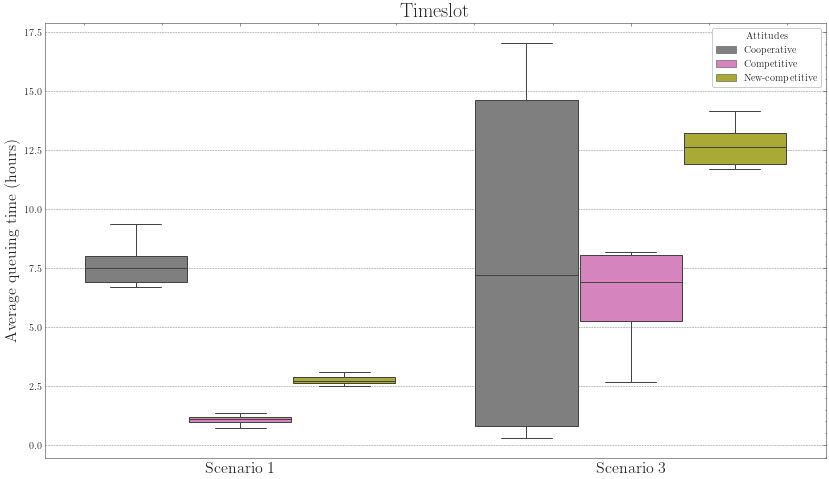

In [ ]:
# per scenario give a boxplot of the average waiting time (sum of every key of 10 / 3)
fig, ax = plt.subplots(figsize = (14, 8))
matrix = np.zeros([number_of_replications*number_of_scenarios,5])

policy = 0
timeslot = 1

# print(matrix)

for scenario in total_dict[policy][timeslot]:
    
    # scenario = 0,1,2,3,4
    
    for replication in total_dict[policy][timeslot][scenario]:
        
        # replication = 0,1,2,3,4,
        
        # filling the columns with cooperative
        matrix[number_of_replications*scenario+replication,2] = (total_dict[policy][timeslot][scenario][replication][11].get("cooperative"))/60
        # with competitive
        matrix[number_of_replications*scenario+replication,3] = (total_dict[policy][timeslot][scenario][replication][11].get("competitive"))/60
        # with new competitive 
        matrix[number_of_replications*scenario+replication,4] = (total_dict[policy][timeslot][scenario][replication][11].get("new-competitive"))/60
        matrix[number_of_replications*scenario+replication,0] = scenario
        matrix[number_of_replications*scenario+replication,1] = replication

matrix = pd.DataFrame(matrix,columns=["scenario","replication","Cooperative", 'Competitive', 'New-competitive'])


dd=pd.melt(matrix,id_vars=['scenario'],value_vars=["Cooperative",'Competitive', 'New-competitive'],var_name='Attitudes')


# selecting only the relevant scenarios 
sns.boxplot(x='scenario',y='value',data=dd,hue='Attitudes', palette = pal_attitudes, showfliers=False)
#sns.swarmplot(x='scenario',y='value',data=dd,hue='Attitudes', palette = pal_attitudes)

ax.set(xlabel=None)
ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 16)
plt.ylabel("Average queuing time (hours)", size = 16)
plt.title("Timeslot",fontsize=20)
plt.savefig(location_figures + "TIMESLOTAverageWaitingPerAttitude.svg")



## change to a swarmplot

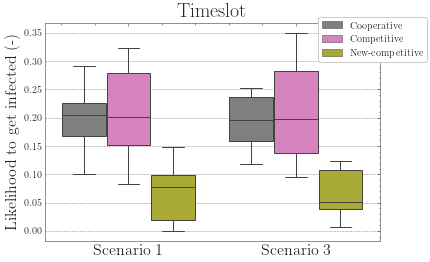

In [ ]:
# creating matrix with the info for the day of the fooddistribution
policy = 0
timeslot = 1

exp6df_t = exp6df[exp6df['policy-implemented'] == 'policy 0 (baseline)']

matrix= np.zeros([number_of_replications*number_of_scenarios,8])
for scenario in total_dict[policy][timeslot]:
    for replication in total_dict[policy][timeslot][scenario]:
        
        run_number = policy*40+timeslot*20+scenario*10+1+replication


#         run_number = scenario * number_of_replications + 1 + replication ## it was like this, see if i need to change
        selected_df = exp6df_t[exp6df_t['run'] == run_number]
        
        number_of_infections = selected_df.loc[selected_df['day'] == 41, 'cum_infected'].iloc[0]
        total_served = selected_df.loc[selected_df['day'] == 41, 'total-served'].iloc[0]
        number_comp_served = selected_df.loc[selected_df['day'] == 41, 'number-competitive-joining'].iloc[0]
        number_newcomp_served = selected_df.loc[selected_df['day'] == 41, 'number-new-competitive'].iloc[0]
        
        
        
        df = pd.DataFrame({'place':total_dict[policy][timeslot][scenario][replication][1],'attitude':total_dict[policy][timeslot][scenario][replication][2]})
        # filter to get only the infections that happened until day 9
        df = df.iloc[0:number_of_infections]  

        # from these, get the infections that happened at the food distribution
        df = df['attitude'][df['place']=='fooddistro']
        

        
        nbr_coop_infected = 0
        nbr_comp_infected = 0
        nbr_ncomp_infected = 0
        
        # count the number of cooperative and competitive people who got infected at the food distribution
        for index, value in df.items():
            
            if value == 'cooperative':
                nbr_coop_infected = nbr_coop_infected + 1
            if value == 'competitive':
                nbr_comp_infected = nbr_comp_infected + 1
            if value == 'new-competitive':
                nbr_ncomp_infected = nbr_ncomp_infected + 1
                
        
        matrix[number_of_replications*scenario+replication,0] = scenario
        matrix[number_of_replications*scenario+replication,1] = replication
        matrix[number_of_replications*scenario+replication,2] = total_served
        matrix[number_of_replications*scenario+replication,3] = number_comp_served
        matrix[number_of_replications*scenario+replication,4] = number_newcomp_served
        matrix[number_of_replications*scenario+replication,5] = nbr_comp_infected
        matrix[number_of_replications*scenario+replication,6] = nbr_coop_infected 
        matrix[number_of_replications*scenario+replication,7] = nbr_ncomp_infected 


matrix = pd.DataFrame(matrix, columns = ["scenario", "replication", "total-served", "competitive-served", "new-competitive-served", "competitive-infected", "cooperative-infected", "new-competitive-infected" ])


# Calculating likelihoods

# COMPETITIVE: nbr of competitive people infected in the food distribution / nbr of competitive people served (number of competitive people served)
# COOPERATIVE: nbr of cooperative people infected in the first food distribution / nbr of cooperative people served (total-served - number of competitive people served)

# likelihood cooperative
#matrix["likelihood-cooperative"] = matrix["cooperative-infected"] / (matrix["total-served"] - matrix["competitive-served"] - matrix["new-competitive-served"]) 
matrix["Cooperative"] = matrix["cooperative-infected"] / (matrix["total-served"] - matrix["competitive-served"]) 
# likelihood competitive
#matrix["likelihood-competitive"] = matrix["competitive-infected"] / (matrix["new-competitive-served"] + matrix["competitive-served"])
matrix["Competitive"] = matrix["competitive-infected"] /  matrix["competitive-served"]
# likelihood new competitive
matrix['New-competitive'] = matrix["new-competitive-infected"] /  matrix["new-competitive-served"]


# Preparing data for visualization
matrix = matrix.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "Cooperative", "Competitive", "New-competitive"],
              var_name='Attitude', value_name='Likelihood')

###

# Visualization (only scenario 1 and scenario 3)
fig, ax = plt.subplots(figsize = (6, 4))

sns.boxplot(x='scenario', y='Likelihood', hue='Attitude', data=matrix, palette=pal_attitudes, showfliers=False, ax = ax)  
ax.set_xlabel(None)
ax.set_ylabel("Likelihood to get infected (-)", size = 16)
ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 16)
plt.title("Timeslot", size = 20)
plt.legend(bbox_to_anchor=(0.8, 1.05))

plt.savefig(location_figures + "TIMESLOTlikelihoodtogetinfected.svg")

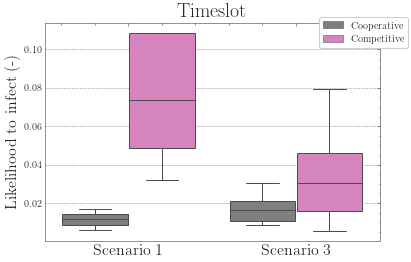

In [ ]:
# creating matrix with the info for the day of the fooddistribution
policy = 0
timeslot = 1

exp6df_t = exp6df[exp6df['policy-implemented'] == 'policy 0 (baseline)']

matrix= np.zeros([number_of_replications*number_of_scenarios,10])
for scenario in total_dict[policy][timeslot]:
    for replication in total_dict[policy][timeslot][scenario]:
        
        run_number = policy*40+timeslot*20+scenario*10+1+replication
        selected_df = exp6df_t[exp6df_t['run'] == run_number]
        
        number_of_infections = selected_df.loc[selected_df['day'] == 41, 'cum_infected'].iloc[0]
        total_served = selected_df.loc[selected_df['day'] == 41, 'total-served'].iloc[0]
        number_comp_served = selected_df.loc[selected_df['day'] == 41, 'number-competitive-joining'].iloc[0]
        number_newcomp_served = selected_df.loc[selected_df['day'] == 41, 'number-new-competitive'].iloc[0]
        
        # if i want to include the number of infectious people around 
        number_infectious_comp = selected_df.loc[selected_df['day'] == 41, 'nbr-infectious-competitive'].iloc[0]
        number_infectious_coop = selected_df.loc[selected_df['day'] == 41, 'nbr-infectious-cooperative'].iloc[0]

        ### now with the focus on the infector (hence the [4])
        df = pd.DataFrame({'place':total_dict[policy][timeslot][scenario][replication][1],'attitude':total_dict[policy][timeslot][scenario][replication][4]})
        # filter to get only the infections that happened until day 9
        df = df.iloc[0:number_of_infections]  

        # from these, get the infections that happened at the food distribution
        df = df['attitude'][df['place']=='fooddistro']
        

        
        nbr_coop_infector = 0
        nbr_comp_infector = 0
        nbr_ncomp_infector = 0
        
        # count the number of cooperative and competitive people who got infected at the food distribution
        for index, value in df.items():
            
            if value == 'cooperative':
                nbr_coop_infector = nbr_coop_infector + 1
            if value == 'competitive':
                nbr_comp_infector = nbr_comp_infector + 1
           
        # took it out to experiment
            if value == 'new-competitive':
                nbr_ncomp_infector = nbr_ncomp_infector + 1
        
        matrix[number_of_replications*scenario+replication,0] = scenario
        matrix[number_of_replications*scenario+replication,1] = replication
        matrix[number_of_replications*scenario+replication,2] = total_served
        matrix[number_of_replications*scenario+replication,3] = number_comp_served
        matrix[number_of_replications*scenario+replication,4] = number_newcomp_served
        matrix[number_of_replications*scenario+replication,5] = nbr_comp_infector
        matrix[number_of_replications*scenario+replication,6] = nbr_coop_infector 
        matrix[number_of_replications*scenario+replication,7] = nbr_ncomp_infector 
        matrix[number_of_replications*scenario+replication,8] = number_infectious_comp
        matrix[number_of_replications*scenario+replication,9] = number_infectious_coop

        
matrix = pd.DataFrame(matrix, columns = ["scenario", "replication", "total-served", "competitive-served", "new-competitive-served", "competitive-infector", "cooperative-infector", "new-competitive-infector", "number-infectious-comp", "number-infectious-coop"])

#matrix["Cooperative"] = matrix["cooperative-infector"] / (matrix["total-served"] - matrix["competitive-served"]) 
#matrix["Competitive"] = matrix["competitive-infector"] / matrix["competitive-served"]
#matrix["New-competitive"] = matrix["new-competitive-infector"] / matrix["new-competitive-served"]

# what if i calculate this dividing by the total number infectious wth that behaviour?
matrix["Cooperative"] = ((matrix["cooperative-infector"] + matrix['new-competitive-infector'])/ (matrix["number-infectious-coop"] * (matrix['total-served'] - matrix['competitive-served'])))*10
matrix["Competitive"] = (matrix["competitive-infector"] / (matrix['number-infectious-comp'] * matrix['competitive-served']))*10 

#matrix["New-competitive"] = matrix["new-competitive-infector"] / matrix["new-competitive-served"]


# Preparing data for visualization
matrix = matrix.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "Cooperative", "Competitive"],
              var_name='Attitude', value_name='Likelihood infecting')


###

# Visualization (only scenario 1 and scenario 3)
fig, ax = plt.subplots(figsize = (6, 4))

sns.boxplot(x='scenario', y='Likelihood infecting', hue='Attitude', data=matrix, palette=pal_attitudes, showfliers=False,ax = ax) 
ax.set_xlabel(None)
ax.set_ylabel("Likelihood to infect (-)", size = 16)
ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 16)
plt.title("Timeslot", size = 20)
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.savefig(location_figures + "TIMESLOTlikelihoodtoinfect.svg")

In [ ]:
evaluation_moments_day = [7,13,35,41]
pal_locations = {"shelter": "lightcoral", "waterpoint": "goldenrod", 'fooddistro':"tab:brown", 'latrine': "tab:cyan", "hc-fac":"cornflowerblue"}

In [ ]:
policy = 0
timeslot = 1
matrix_location_infections = pd.DataFrame()

exp_comb_p2 = exp6df[exp6df['policy-implemented'] == 'policy 0 (baseline)']

for scenario in total_dict[policy][timeslot]:

    for replication in total_dict[policy][timeslot][scenario]: 
    
        run_number = policy*40+timeslot*20+scenario*10+1+replication
        
        selected_df = exp_comb_p2[exp_comb_p2['run'] == run_number ] 
        
        tempdict = {}
        
        for day in evaluation_moments_day:
            
            number_of_infections = selected_df.loc[selected_df['day'] == day,'cum_infected'].iloc[0]
            tempdict[day] = total_dict[policy][timeslot][scenario][replication][1][0:number_of_infections - 1]
            
        total_dict[policy][timeslot][scenario][replication][10] = tempdict
        
matrix= np.zeros([number_of_replications*number_of_scenarios, 6])

locations = ['shelter','waterpoint', 'latrine', 'hc-fac', 'fooddistro']
    
for scenario in total_dict[policy][timeslot]:
    for replication in total_dict[policy][timeslot][scenario]:  
        total_dict[policy][timeslot][scenario][replication][11] = {7: 0, 13: 0, 35: 0, 41: 0}
        
        for evaluation_day in total_dict[policy][timeslot][scenario][replication][10]:
            count_shelter = 0
            count_waterpoint = 0
            count_latrine = 0
            count_hcfac = 0
            count_fooddistro = 0
            
            temp_loc_dict = {}
            
            for entry in total_dict[policy][timeslot][scenario][replication][10][evaluation_day]:
      
                if entry == 'shelter':
                    count_shelter = count_shelter + 1
                if entry == 'waterpoint':
                    count_waterpoint = count_waterpoint + 1
                if entry == 'latrine':
                    count_latrine = count_latrine + 1
                if entry == 'hcfac':
                    count_hcfac = count_hcfac + 1
                if entry == 'fooddistro':
                    count_fooddistro = count_fooddistro + 1
            
            
            temp_loc_dict[evaluation_day] = {'shelter': count_shelter, 'waterpoint': count_waterpoint,
                                               'latrine': count_latrine, 'hcfac': count_hcfac,
                                               'fooddistro': count_fooddistro}
            
            total_dict[policy][timeslot][scenario][replication][11][evaluation_day] = temp_loc_dict[evaluation_day]
            
            
            
## CREATING 4 MATRIX TO STORE THE DATA FOR THE INFECTION PER LOCATION

# For the first moment of evaluation

for day in evaluation_moments_day:
    matrix_firstmoment = np.zeros([number_of_replications*number_of_scenarios,7])
    for scenario in total_dict[policy][timeslot]:
        for replication in total_dict[policy][timeslot][scenario]:
            matrix_firstmoment[number_of_replications*scenario+replication,0] = scenario
            matrix_firstmoment[number_of_replications*scenario+replication,1] = replication
            matrix_firstmoment[number_of_replications*scenario+replication,2] = total_dict[policy][timeslot][scenario][replication][11][day]['shelter']
            matrix_firstmoment[number_of_replications*scenario+replication,3] = total_dict[policy][timeslot][scenario][replication][11][day]['waterpoint']
            matrix_firstmoment[number_of_replications*scenario+replication,4] = total_dict[policy][timeslot][scenario][replication][11][day]['latrine']
            matrix_firstmoment[number_of_replications*scenario+replication,5] = total_dict[policy][timeslot][scenario][replication][11][day]['hcfac']
            matrix_firstmoment[number_of_replications*scenario+replication,6] = total_dict[policy][timeslot][scenario][replication][11][day]['fooddistro']

    matrix_firstmoment = pd.DataFrame(matrix_firstmoment, columns = ["scenario", "replication", "shelter", "waterpoint", "latrine", "hc-fac", "fooddistro" ])
    matrix_firstmoment = matrix_firstmoment.melt(id_vars=['scenario', 'replication'], 
                value_vars=[ "shelter", "waterpoint", "latrine", "fooddistro"],
                var_name='Location', value_name='Infections')

    matrix_firstmoment["policy"] = policy
    matrix_firstmoment["day"] = day
    matrix_location_infections = matrix_location_infections.append(matrix_firstmoment, ignore_index = True)


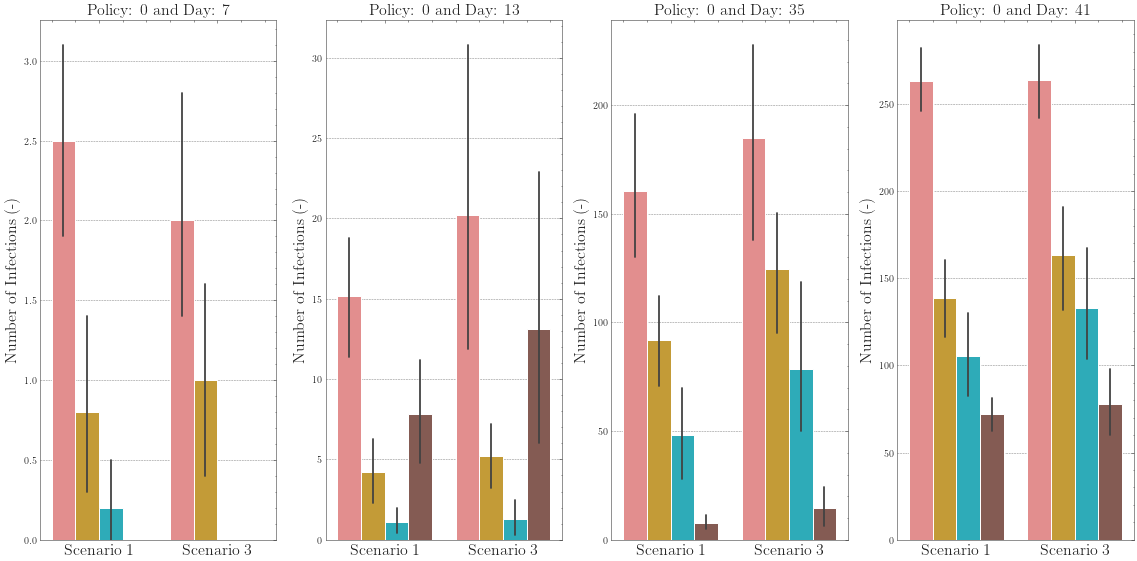

In [ ]:
fig, axes = plt.subplots(figsize = (16, 8),  nrows=1, ncols=4, sharex = True)

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

axes = trim_axs(axes, 12)

for day, ax in zip(evaluation_moments_day, axes):
    df = matrix_location_infections[(matrix_location_infections["policy"] == 0) & (matrix_location_infections["day"] == day)]
    sns.barplot(x='scenario', y='Infections', hue='Location', data=df, palette=pal_locations, ax = ax)
    ax.set_title("Policy: " + str(policy) + " and " + "Day: " + str(day), size = 16)
    ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 16)
    ax.set_xlabel(None)
    ax.set_ylabel("Number of Infections (-)", size = 16)

    if (policy == 1) & (day == 41):
        ax.legend(bbox_to_anchor = (1.5, 1), prop={'size': 16})
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig(location_figures + "TIMESLOT_distribution_all.svg")
plt.show()

In [ ]:
exp6df_timeslot = exp6df.loc[(exp6df['policy4?'] == True) & (exp6df['policy-implemented'] == 'policy 0 (baseline)')]

In [ ]:
exp6df_timeslot = exp6df_timeslot.rename({"cum_infected" : "cum-infected"}, axis = 1)
exp6df_timeslot_s1_s3 = exp6df_timeslot[(exp6df_timeslot['scenario:percentage-competitive'] == 10) | (exp6df_timeslot['scenario:percentage-competitive'] == 30)]

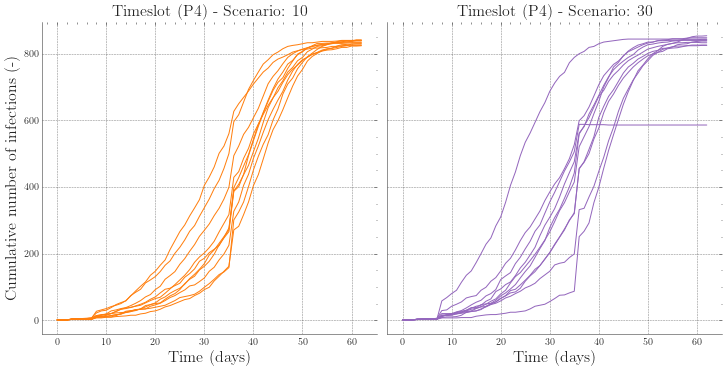

In [ ]:
g = sns.relplot(data=exp6df_timeslot_s1_s3, x="day", y="cum-infected", hue="scenario:percentage-competitive", col='scenario:percentage-competitive', row="policy-implemented", kind = "line",  palette = pal_scenarios_10, style = 'run', legend = False, dashes= False).set_axis_labels("Time (days)", "Cumulative number of infections (-)", size = 16).set_titles("Timeslot (P4) - Scenario: {col_name}% competitive", size = 16)


g.savefig(location_figures + "TIMESLOT_CumulativeInfections_Spaghetti_all.svg")

In [ ]:
exp6df_timeslot_s1_s3["daily-infections"].where(~(exp6df_timeslot_s1_s3["daily-infections"] < 0), other = 0, inplace = True)

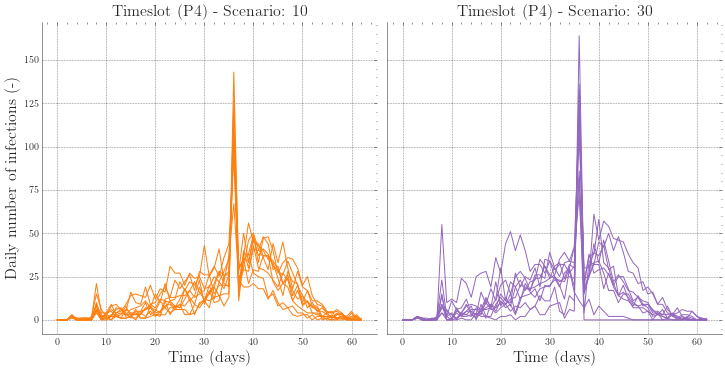

In [ ]:
g = sns.relplot(data=exp6df_timeslot_s1_s3, x="day", y="daily-infections", hue="scenario:percentage-competitive", col='scenario:percentage-competitive', row="policy-implemented", kind = "line",  palette = pal_scenarios_10, style = 'run', legend = False, dashes= False).set_axis_labels("Time (days)", "Daily number of infections (-)", size = 16).set_titles("Timeslot (P4) - Scenario: {col_name}% competitive", size = 16)

g.savefig(location_figures + "TIMESLOT_DailyInfections_Spaghetti_all.svg")

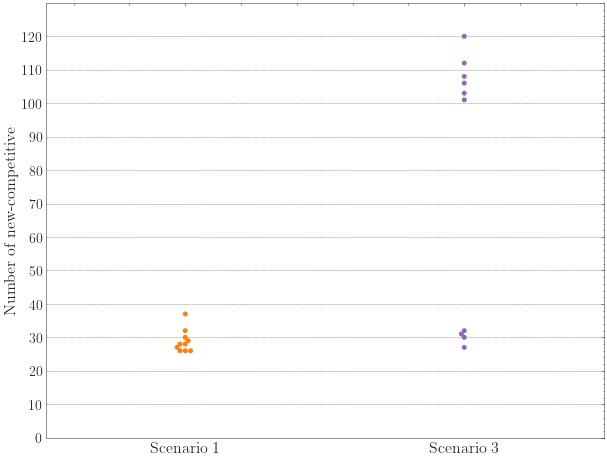

In [ ]:
### Trying to visualize the number of people turning new-competitive per scenario

### Looking into how many people turned new-competitive per run per scenario
exp6df_timeslot_newcomp = exp6df_timeslot_s1_s3[exp6df_timeslot_s1_s3['day'] == 9]



fig, ax = plt.subplots(figsize=(10,8))

sns.swarmplot(x='scenario:percentage-competitive', y='number-new-competitive', hue='scenario:percentage-competitive', data=exp6df_timeslot_newcomp, palette = pal_scenarios_10, ax = ax)  
ax.get_legend().remove()

ax.set_xticklabels(["Scenario 1","Scenario 3"], size = 16)
ax.set_xlabel(None)
ax.set_ylabel("Number of New Competitve People (-)")

# Correct yticks, again, make them convenient. the default 100 is a good step here i guess 
# Correct y-lim
ax.set_ylim([0,130])

yticks = np.arange(0,130,10)

yticklabels = list() # 
for yt in range(len(yticks)):
    yticklabels.append( str(int(yticks[yt])))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=14)

#plt.xlabel("Scenario", size = 16)
plt.ylabel("Number of new-competitive", size = 16)

plt.savefig(location_figures + "TIMESLOTNumberNewComp_all.svg")

In [ ]:
## doesnt show much.. quite similar to the one before 

Text(3246.9545481779755, 0.5, 'new infections')

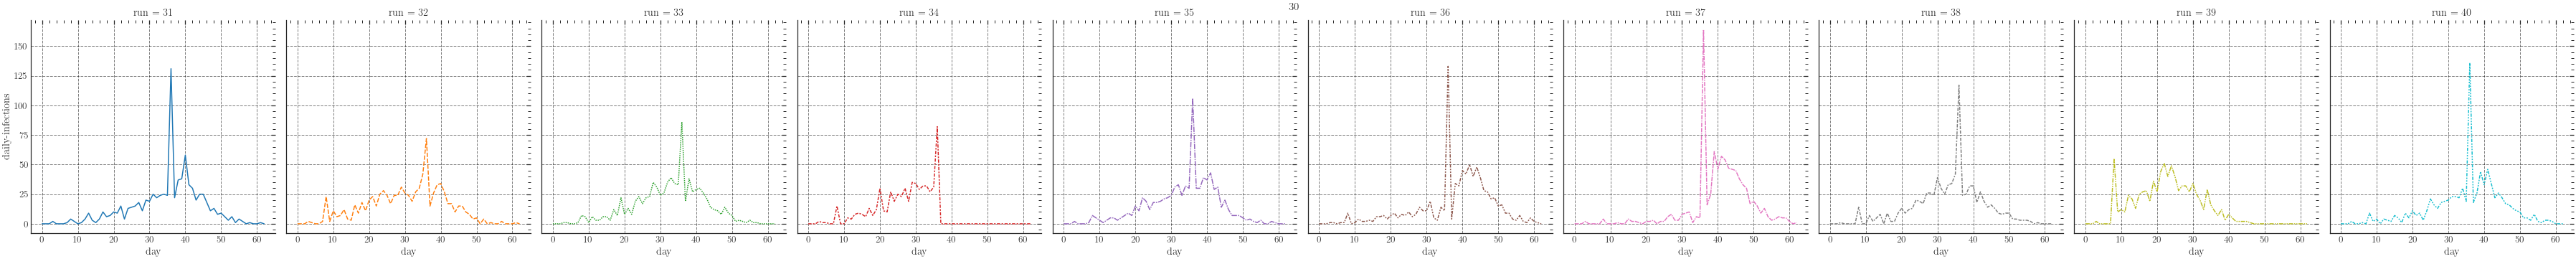

In [ ]:
## Trying to observe what happened at the run that fully stopped in the middle


base30 = exp6df_timeslot_s1_s3[exp6df_timeslot_s1_s3['scenario:percentage-competitive'] == 30]
base30

sns.set_context('notebook', font_scale = 1.2)
g = sns.relplot(x = 'day', y = 'daily-infections', col = 'run', style = 'run', legend = False, palette = 'tab10', hue = 'run', kind = 'line', data = base30)
g.fig.suptitle('30% competitive: per run: to find broken runs', fontsize=15)
plt.xlabel('day')
plt.ylabel("new infections")


In [ ]:
base30[base30['run'] == 34]


,index,scenario:percentage-competitive,policy-implemented,policy4?,run,day,cum-infected,infections-provoked-competitive-total,infections-provoked-cooperative-total,nbr-infectious,...,number-competitive-joining,number-new-competitive,time-in-queue-average,total-served,daily-infections,daily-provoked-cooperative,daily-provoked-competitive,R0,r0-cooperative,r0-competitive
3339,3339,30,policy 0 (baseline),True,34,0,1,0,0,0,...,0,0,0.000000,0,0.0,0.0,0.0,-inf,NaN,NaN
3340,3340,30,policy 0 (baseline),True,34,1,1,0,0,0,...,0,0,0.000000,0,0.0,0.0,0.0,NaN,NaN,NaN
3341,3341,30,policy 0 (baseline),True,34,2,1,0,0,0,...,0,0,0.000000,0,0.0,0.0,0.0,NaN,NaN,NaN
3342,3342,30,policy 0 (baseline),True,34,3,3,2,0,1,...,0,0,0.000000,0,2.0,0.0,2.0,2.0,NaN,2.0
3343,3343,30,policy 0 (baseline),True,34,4,4,3,0,1,...,0,0,0.000000,0,1.0,0.0,1.0,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,3397,30,policy 0 (baseline),True,34,58,586,227,360,179,...,106,203,560.727599,279,0.0,0.0,0.0,0.0,0.0,0.0
3398,3398,30,policy 0 (baseline),True,34,59,586,227,360,179,...,106,203,560.727599,279,0.0,0.0,0.0,0.0,0.0,0.0
3399,3399,30,policy 0 (baseline),True,34,60,586,227,360,179,...,106,203,560.727599,279,0.0,0.0,0.0,0.0,0.0,0.0
3400,3400,30,policy 0 (baseline),True,34,61,586,227,360,179,...,106,203,560.727599,279,0.0,0.0,0.0,0.0,0.0,0.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff502ce8-25da-4e4a-b841-dc0e7d23f282' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>